Purpose: Compare calibration of the heat balance model climate sensitivity and surface ocean mixed layer thermal inertia parameters against 1892-2017  increases in temperature over the 1650-1749 average. Then extrapolate the combined CO2, N2O, and heat balances using the calibrated heat balance parameters.

In [1]:
%reset -f
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import mpmath
from scipy.special import erf,hyp2f1
from scipy import log,exp,sqrt
from scipy.fftpack import dct
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize_scalar
from scipy.optimize import least_squares
from scipy import interpolate
os.chdir('C:\\Users\\cd7\\Desktop\\Heat18Temperature')

Read the specified input file

In [2]:
df1 = pd.read_excel('C:\\Users\\cd7\\Desktop\\Heat18Temperature\\heat18parameters13jan.xlsx')
df1.to_csv('heat19parameters13jan.csv',header=False,index=False)
df1 = pd.read_csv('heat19parameters13jan.csv')

df2 = pd.read_excel('C:\\Users\\cd7\\Desktop\\Heat18Temperature\\heat18warming2jan200-2017.xlsx')
df2.to_csv('heat19warming2jan200-2017.csv',header=False,index=False)
df2 = pd.read_csv('heat19warming2jan200-2017.csv')

df3 = pd.read_excel('C:\\Users\\cd7\\Desktop\\Heat18Temperature\\heat18fixwarming8jan200-2017.xlsx')
df3.to_csv('heat19fixwarming8jan200-2017.csv',header=False,index=False)
df3 = pd.read_csv('heat19fixwarming8jan200-2017.csv')

df4 = pd.read_excel('C:\\Users\\cd7\\Desktop\\Heat17CO2\\heat17-co2-1-2017dec18.xlsx')
df4.to_csv('heat19-co2-1-2017dec18.csv',header=False,index=False)
df4 = pd.read_csv('heat19-co2-1-2017dec18.csv')

df5 = pd.read_excel('C:\\Users\\cd7\\Desktop\\Heat18_integration_coeff_table.xlsx')
# print (df5)

df6 = pd.read_csv('C:\\Users\\cd7\\Desktop\\Heat17Forcings\\heat18parameters06jan.csv')


Formulate the exported file name

In [3]:
out1 = 'extrapolate';
out2 = 'co2tau';
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] # abbreviations for months to insert in output file name)
date = datetime.date.today().strftime("%Y-%m-%d")
date_split = date.split('-')
yrs = str(int(date_split[0])-2000)
seq = [out1, yrs, out2, months[int(date_split[1])-1], date_split[2] ]
seperator = ','
filename = seperator.join(seq).replace(',', '')
print (filename)

extrapolate18co2tauoct29


Some self-defined constants

In [4]:
fix0 = 1
fix1 = 1
fixvolcano = 1
fix6 = 1.0
nave = 11
tdrop = 1551 + round(nave*((2017-1750)/nave-(2017-1750)//nave))
print (tdrop)

1554


Data
Global average temperature direct measurements as deviations from 1951-1980 mean.

In [5]:
ndrop = 1450
file2use = df2.iloc[ndrop:-1]
file2use.index = np.arange(0, len(file2use))
file3use = df3.iloc[ndrop:-1]
file3use.index = np.arange(0, len(file3use))
yrs = file2use.iloc[:,0]
temps = file2use.iloc[:,1]
fixtemps = file3use.iloc[:,1]

In [6]:
warm = df2.iloc[(ndrop+100):-1]
fixwarm = df3.iloc[(ndrop+100):-1]
warmtoave = df2.iloc[tdrop:-1]
warmtoave.index = np.arange(0, len(warmtoave))
yrstoave = warmtoave.iloc[:,0]
tempstoave = warmtoave.iloc[:,1]
mave = len(yrstoave)/nave
yrstoave = yrstoave.astype(float)
yrsave = yrstoave.groupby(np.arange(len(yrstoave))//nave).mean()
tempstoave = tempstoave.astype(float)
tempsave = tempstoave.groupby(np.arange(len(tempstoave))//nave).mean()
# print(warm)

In [7]:
b1 = df1.iloc[:,0]
b2 = df1.iloc[:,1]
b3 = df1.iloc[:,2]
b4 = df1.iloc[:,3]

b5 = df6.iloc[:,0:1]
b5 = b5['b1'].tolist()
b5 = list(map(float, b5))
print (b5)

b6 = df6.iloc[:,1:2]
b6 = b6['JulianYrEtc'].tolist()
b6 = list(map(float, b6))

b7 = df6.iloc[:,2:3]
b7 = b7['b3(Years)'].tolist()
b7 = list(map(float, b7))

b8 = df6.iloc[:,3:4]
b8 = b8['b4'].tolist()
b8 = list(map(float, b8))

tup0 = b4[25]
ch40 = b3[18]
life = b4[8]
t0 = b4[11]
print (t0)
tmax = b4[12]
# gtonnecperppm = b4[2]
gtonnecperppm = float(b4[2])

c18 = 339.873
c24 = 383.647
eps0 = 0.620523
print (life)

[10.6644, 3.4656599999999997, 18.252, 0.242542, 0.199856, 0.770546, 0.964413, 64.1562, 176.655, 5.14088, 2.39098, 0.360664, 0.169096, 3.4656599999999997, 0.592935, 0.147705, 8.50988, 0.0, 0.0, 0.0, 0.292705, 0.0772446, 3.8108800000000005, 0.15466, 0.0461415, 0.13156700000000002, 0.18290399999999998, 0.13156700000000002]
1750.0
9.51428


Trial values of adjustable parameters c1, c2, and c3

In [8]:
c200 = 1.16
c220 = 0.86055
c230 = 0.24685
# c30 = 30.667*fix3
c30 = 30.667
c10 = 1*fix1
c00 = fix0  # multiplies aerosols less black carbon on snow
ctry2 = 1067.3112319440002
# c20 = ctry2*coef2
nm = [[3, 2, 4, 5, 6, 7],[9, 9, 9],[11, 11, 11, 23],[12],[13],[16,17],[14,15],[22,28],[24, 25, 26, 27],[29,30]]
# create xnm0 list
xnm0 = []
for n in range(0,len(nm)):
    sub_list=[]
    for m in range(0,len(nm[n])):
        x = (t0-b2[nm[n][m]-1])/b3[nm[n][m]-1]
        sub_list.append(float(x))
    xnm0.append(sub_list)
print (xnm0)

[[-8.912624340971526, -1.5560182540706204, -8.19754796844041, -32.85303215208119, -22.968805442510636, -15.976109753212969], [-5.410597434732601, -5.410597434732601, -5.410597434732601], [-6.283576980886852, -6.283576980886852, -6.283576980886852, -40.5836780212064], [-30.582698520320662], [-15.514434251451279], [-10.0847288676236, -3.3308494783904616], [-1.5560182540706204, -8.814519270246658], [-22.75, -34.5], [0.6649853174864708, 0.7126112909360466, -9.470909090909096, -47.9909090909091], [-1.5560182540706204, -7.0628848410577385]]


Input parameter file locations for CO2, CH4, N20, other, contrail, albedo, aerosol, volcano, and irradiance forcings, new independent variables xnm, climate sensitivity parameters, snm, and integral types inm

CO2-Industrial:

e11(annual emissions in Gtonne of CO2) is shown as logistic function,so the first general type of integrand is logistic function.
u = 1/(1 + exp(-x)), where x=(t-b2)/b3.

In [9]:
def intlogisitic(s,x,x0):
    y = exp(s*x)*(-1+ hyp2f1(1,s,1+s,-exp(x)) + s*log(1+exp(x))-s*log(1+exp(x0)))/(s**2)
    return y

def finalint1(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (-1+hyp2f1(1,s,1+s,-exp(x))-exp(s*(-x+x0))*(-1+hyp2f1(1,s,1+s,-exp(x0)))+s*log(1+exp(x))-s*log(1+exp(x0)))/(s**2)
    return y

print (finalint1(2,5,2100,df5.iloc[0][1],df5.iloc[0][2],b3[nm[0][0]-1],xnm0[0][0]))

d11=b2[17]*b4[3]*b4[4]*b1[nm[0][0]-1]*b3[nm[0][0]-1]/gtonnecperppm

def tau11(coef2,fix3,t):
    y = c10*(b3[nm[0][0]-1]/(c30*fix3))*d11*finalint1(coef2,fix3,t,df5.iloc[0][1],df5.iloc[0][2],b3[nm[0][0]-1],xnm0[0][0])
    return y
print (tau11(2,5,2100))
print (tup0)

# carbon dioxide radiative forcing formula(industrial)
x0 = (t0-b6[2])/b7[2]
print (x0)
def co2ind(t):
    y = b8[3]*b8[4]*b5[2]*b7[2]*(log(1+exp((t-b6[2])/b7[2]))-log(1+exp(x0)))/gtonnecperppm
    return y

co2ind = np.vectorize(co2ind)

print (co2ind(2000))

1.7216456984687145
0.5619506758771825
286.681
-8.912624340971526
53.71312155198684


CO2-Land Use:

have two kinds of integrands namely: 1.the time derivative of a logistic function, 2, four gaussians functions, where gaussian function is of the form $(b1/sqrt(2*pi))*exp(-x^2/2)$.

CO2-Land Use: Logistic increase

In [10]:
def intdlogistic(s,x,x0):
    y = exp(s*x)*(1-(1+exp(x0))*hyp2f1(1,s,1+s,-exp(x)))/((1+exp(x0))*s)
    return y

def finalint2(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*(exp(s*x)-exp(s*x0)-exp(s*x)*(1+exp(x0))*hyp2f1(1,s,1+s,-exp(x))+exp(s*x0)*(1+exp(x0))*hyp2f1(1,s,1+s,-exp(x0)))/(s*(1+exp(x0)))
    return y

print (finalint2(2,5,2000,df5.iloc[1][1],df5.iloc[1][2],b3[nm[0][1]-1],xnm0[0][1]))

d12 = b2[17]*b4[3]*b1[nm[0][1]-1]*b4[nm[0][1]-1]/gtonnecperppm

def tau12(coef2,fix3,t):
    y = c10*(b3[nm[0][1]-1]/(c30*fix3))*d12*finalint2(coef2,fix3,t,df5.iloc[1][1],df5.iloc[1][2],b3[nm[0][1]-1],xnm0[0][1])
    return y
print (b3[nm[0][1]-1])
print (d12)
print (tau12(2,5,2000))

# carbon dioxide radiative forcing formula(land use)

def dlogint(t):
    y = b5[1]/(1 + np.exp(-(t - b6[1])/b7[1]))
    return y
dlogint0 = dlogint(t0)

dlogint = np.vectorize(dlogint)

def co2logintland(t):
    y = b8[1]*(dlogint(t) - dlogint0)/gtonnecperppm
    return y

def gaussint(t,b1g,b2g,b3g):
    y = b1g*b3g*np.sqrt(np.pi/2)*(-erf((b2g - t)/(b3g*np.sqrt(2))) + erf((b2g - t0)/(b3g*np.sqrt(2))))
    return y

gaussint = np.vectorize(gaussint)

bg = [] # results from co2 landuse fit from (g1 b1 d1) to (g4 b4 d4).
for i in range(3,7):
    sub_list=[]
    for m in range(0,3):
        x = df6.iloc[i,m].tolist()
        sub_list.append(float(x))
    bg.append(sub_list)

def gaussland(t):
    y = gaussint(t,bg[0][0],bg[0][1],bg[0][2])+gaussint(t,bg[1][0],bg[1][1],bg[1][2])+gaussint(t,bg[2][0],bg[2][1],bg[2][2])+gaussint(t,bg[3][0],bg[3][1],bg[3][2])
    return y

def co2gauss(t):
    y = gaussland(t)/gtonnecperppm
    return y

def co2land(t):
    y = b8[3]*(co2logintland(t) + co2gauss(t))
    return y

0.03659397151914998
162.813
1.5506248923169756
0.06025097488521093


CO2-Land Use: Erf functions

In [11]:
def interror(s,x,x0):
    y = sqrt(np.pi/2)*(exp(s*x)*erf(x/sqrt(2))-exp(s**2)*erf((-s+x)/sqrt(2))-exp(s*x)*erf(x0/sqrt(2)))/s
    return y

def finalint3(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*sqrt(np.pi/2)*(exp(s*x)*erf(x/sqrt(2))-exp(s**2/2)*erf((-s+x)/sqrt(2))-exp(s*x)*erf(x0/sqrt(2))+exp(s**2/2)*erf((-s+x0)/sqrt(2)))/s
    return y

d13 = b2[17]*b4[3]*b1[nm[0][2]-1]*b3[nm[0][2]-1]/gtonnecperppm

def tau13(coef2,fix3,t):
    y = c10*(b3[nm[0][2]-1]/(c30*fix3))*d13*finalint3(coef2,fix3,t,df5.iloc[2][1],df5.iloc[2][2],b3[nm[0][2]-1],xnm0[0][2])
    return y

print (tau13(2,5,2000))

d14 = b2[17]*b4[3]*b1[nm[0][3]-1]*b3[nm[0][3]-1]/gtonnecperppm

def tau14(coef2,fix3,t):
    y = c10*(b3[nm[0][3]-1]/(c30*fix3))*d14*finalint3(coef2,fix3,t,df5.iloc[3][1],df5.iloc[3][2],b3[nm[0][3]-1],xnm0[0][3])
    return y

print (tau14(2,5,2000))

d15 = b2[17]*b4[3]*b1[nm[0][4]-1]*b3[nm[0][4]-1]/gtonnecperppm

def tau15(coef2,fix3,t):
    y = c10*(b3[nm[0][4]-1]/(c30*fix3))*d15*finalint3(coef2,fix3,t,df5.iloc[4][1],df5.iloc[4][2],b3[nm[0][4]-1],xnm0[0][4])
    return y

d16 = b2[17]*b4[3]*b1[nm[0][5]-1]*b3[nm[0][5]-1]/gtonnecperppm

def tau16(coef2,fix3,t):
    y = c10*(b3[nm[0][5]-1]/(c30*fix3))*d16*finalint3(coef2,fix3,t,df5.iloc[5][1],df5.iloc[5][2],b3[nm[0][5]-1],xnm0[0][5])
    return y

def tau1(coef2,fix3,t):
    y = tau11(coef2,fix3,t) + tau12(coef2,fix3,t) + tau13(coef2,fix3,t) + tau14(coef2,fix3,t) + tau15(coef2,fix3,t) + tau16(coef2,fix3,t)
    return y

print (tau1(2,5,2000))

0.0033077746881360367
0.0007575933642601274
0.1470527296421471


Define total carbon dioxide radiative forcing including both land use and industrial

In [12]:
c0 = 278

def carbonconc(t):
    y =  co2land(t) + co2ind(t) + c0
    return y

print (carbonconc(2000))

alpha = 5.35

def f1(t):
    y = alpha*log((co2land(t)+ co2ind(t)+c0)/c0)
    return y

print (f1(2000))
# print (log(10))

369.0430333705964
1.515612976555989


CH4

For methane, due to its radiative forcing formula contains three terms, respectively are 1. logistic function,2. first order time derivative of logistic function, and second order time derivative of logistic function.
Let u(x) = 1/(1+exp(-x)), and up(x) = u(x)*(1-u(x)) and upp(x) = u(x)*(1-u(x))*(1-2*u(x)).

In [13]:
eps = b4[nm[1][0]-1]/b3[nm[1][0]-1]
print (eps)
def finalint4(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (-(exp(x + x0) + s + exp(2*x0)*s + exp(x0)* (1 + 2*s)-(1 + exp(x))*(1 + exp(x0))**2*s*hyp2f1(1,s,1 + s, -exp(x)))/(1 + exp(x))+ exp(s*(-x + x0))*(s + exp(x0)*(1 + s) - (1 + exp(x0))**2*s*hyp2f1(1, s,1 + s, -exp(x0))))/((1 + exp(x0))**2*s)
    return y

def finalint5(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*(2*exp((3 + s)*x0)/((1 +exp(x0))**3*s)-2*exp(s*x + 3*x0)/((1 +exp(x0))**3*s)-(3*exp((2 + s)*x0))/((1 +exp(x0))**2*s)+(3*exp(s*x+2*x0))/((1+exp(x0))**2*s) + exp((1 + s)*x0)/(s +exp(x0)*s) - exp(s*x + x0)/(s + exp(x0)* s) + exp((1 + s)*x)*hyp2f1(1, 1 + s, 2 + s, -exp(x))/(1 + s) - exp((1 + s)*x0)*hyp2f1(1, 1 + s, 2 + s, -exp(x0))/(1 + s) -
        3*exp((2 + s)*x)*(2 + s -(1 +exp(x))*(1 + s)*hyp2f1(1, 2 + s,3 + s, -exp(x)))/((1 + exp(x))*(2 + s)) + 3*exp((2 + s)*x0)*(2 + s - (1 +exp(x0))*(1 + s)*hyp2f1(1, 2 + s,3 + s, -exp(x0)))/((1 + exp(x0))*(2 + s)) + exp((3 + s)*x)*(-(s + exp(x)*(1 + s))/((1 + exp(x))**2) + ((2 + 3*s + s**2)*hyp2f1(1, 3 + s, 4 + s, -exp(x))/(3 + s))) + exp((3 + s)*x0)*((s + exp(x0)*(1 + s))/(1 + exp(x0))**2 - ((2 + 3*s + s**2)*hyp2f1(1, 3 + s, 4 + s, -exp(x0))/(3 + s))))
    return y

d21 = b2[18]*b4[nm[1][0]-1]*b1[nm[1][0]-1]
d22 = -d21*eps
d23 = d21*eps**2

def tau21(coef2,fix3,t):
    y = c10*(b3[nm[1][0]-1]/(c30*fix3))*d21*finalint2(coef2,fix3,t,df5.iloc[6][1],df5.iloc[6][2],b3[nm[1][0]-1],xnm0[1][0])
    return y
print(tau21(2,5,2070))

def tau22(coef2,fix3,t):

    y = c10*(b3[nm[1][1]-1]/(c30*fix3))*d22*finalint4(coef2,fix3,t,df5.iloc[7][1],df5.iloc[7][2],b3[nm[1][1]-1],xnm0[1][1])
    return y
print(tau22(2,5,2200))

def tau23(coef2,fix3,t):
    y = c10*(b3[nm[1][2]-1]/(c30*fix3))*d23*finalint5(coef2,fix3,t,df5.iloc[8][1],df5.iloc[8][2],b3[nm[1][2]-1],xnm0[1][2])
    return y

print (tau23(2,5,2100))
# print(finalint5(2,5,2100,df5.iloc[6][1],df5.iloc[6][2],b3[nm[1][0]-1],xnm0[1][0]))

def tau2(coef2,fix3,t):
    y = tau21(coef2,fix3,t) + tau22(coef2,fix3,t) + tau23(coef2,fix3,t)
    return y
# print (df5.iloc[6][1],df5.iloc[6][2],b3[nm[1][0]-1],xnm0[1][0])
print (tau2(2,5,2100))

0.2299045998898114
0.08808563500311804
-8.758928177700023e-05
-0.00033307923018555433
0.09328515191039007


CH4 Modified radiative forcing

In [14]:
epsilon1 = life/b7[8]
beta = 0.036
f0f = 0.47
m0 = 722
n0 = 270
e1 = 0.75
e2 = 1.52
f1f = 0.0000201 
f2f = 5.31*10**-15
print (epsilon1)

def u(t):
    y = 1/(1 + np.exp(-(t-b6[8])/b7[8]))
    return y

u = np.vectorize(u)

def ch4fit(t):
    y = ch40 + life*b5[8]*u(t)*(1-epsilon1*(1-u(t))+epsilon1**2*(1-u(t))*(1-2*u(t)))
    return y
print (ch4fit(2000))

def fch4(t):
    y = f0f*log(1+f1f*(ch4fit(t)*n0)**e1+f2f*ch4fit(t)*(ch4fit(t)*n0)**e2)
    return y

f00 = f0f*log(1 + f1f*(m0*n0)**e1 + f2f*m0*(m0*n0)**e2)

def f2(t):
    y = beta*(sqrt(ch4fit(t))-sqrt(m0))-(fch4(t)-f00)
    return y

print (f2(2000))
print (b5[8])

0.2299045998898114
1725.1499963712517
0.4632033480679
176.655


N2O

The radiative forcing formula of nitrous oxide is shown as polylog function of order 2 and 3.

In [15]:
delta = b3[nm[2][0]-1]/b4[nm[2][0]-1]
d31 = b2[19]*b1[nm[2][0]-1]*b3[nm[2][0]-1]
d32 = d31*delta
d33 = -d31*delta**2
d34 = b2[19]*b1[nm[2][3]-1]
# print (d33)
def finalint6(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
#     y = (-1+ hyp2f1(1,s,1+s,-exp(x))+s*log(1+exp(x))-exp(s*(-x+x0))*(-1+hyp2f1(1,s,1+s,-exp(x0))+s*log(1+exp(x0)))+s**2*mpmath.polylog(2,-exp(x))-s**2*mpmath.polylog(2,-exp(x0)))/s**3
    y = (-1+ hyp2f1(1,s,1+s,-exp(x))+s*log(1+exp(x))-exp(s*(-x+x0))*(-1+hyp2f1(1,s,1+s,-exp(x0))+s*log(1+exp(x0)))+s**2*float(mpmath.polylog(2,-exp(x)))-s**2*float(mpmath.polylog(2,-exp(x0))))/s**3
    return y

finalint6 = np.vectorize(finalint6)

def finalint7(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
#     y = (-1/s**4)*(-1+hyp2f1(1,s,1+s,-exp(x)) + s*log(1+exp(x))+s**2*mpmath.polylog(2,-exp(x))-exp(s*(-x+x0))*(-1+hyp2f1(1,s,1+s,-exp(x0))+s*log(1+exp(x0))+s**2*mpmath.polylog(2,-exp(x0)))-s**3*mpmath.polylog(3,-exp(x))+s**3*mpmath.polylog(3,-exp(x0)))
    y = (-1/s**4)*(-1+hyp2f1(1,s,1+s,-exp(x)) + s*log(1+exp(x))+s**2*float(mpmath.polylog(2,-exp(x)))-exp(s*(-x+x0))*(-1+hyp2f1(1,s,1+s,-exp(x0))+s*log(1+exp(x0))+s**2*float(mpmath.polylog(2,-exp(x0))))-s**3*float(mpmath.polylog(3,-exp(x)))+s**3*float(mpmath.polylog(3,-exp(x0))))
    return y

finalint7 = np.vectorize(finalint7)

def finalint8(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (hyp2f1(1, s, 1 + s, -exp(x)) - exp(s*(-x + x0))*hyp2f1(1, s, 1 + s, -exp(x0)))/s
    return y

def tau32(coef2,fix3,t):
    y = c10*(b3[nm[2][1]-1]/(c30*fix3))*d32*finalint6(coef2,fix3,t,df5.iloc[9][1],df5.iloc[9][2],b3[nm[2][1]-1],xnm0[2][1])
    return y

def tau33(coef2,fix3,t):
    y = c10*(b3[nm[2][2]-1]/(c30*fix3))*d33*finalint7(coef2,fix3,t,df5.iloc[10][1],df5.iloc[10][2],b3[nm[2][2]-1],xnm0[2][2])
    return y

def tau31(coef2,fix3,t):
    y = c10*(b3[nm[2][0]-1]/(c30*fix3))*d31*finalint1(coef2,fix3,t,df5.iloc[12][1],df5.iloc[12][2],b3[nm[2][0]-1],xnm0[2][0])
    return y

def tau34(coef2,fix3,t):
    y = c10*(b3[nm[2][3]-1]/(c30*fix3))*d34*finalint8(coef2,fix3,t,df5.iloc[11][1],df5.iloc[11][2],b3[nm[2][3]-1],xnm0[2][3])
    return y

def tau3(coef2,fix3,t):
    y = tau31(coef2,fix3,t) + tau32(coef2,fix3,t) +tau33(coef2,fix3,t) +tau34(coef2,fix3,t)
    return y
# print (tau3(2,5,2100))
# print (delta)

f0f = 0.47
m0 = 722
n0 = 270
e1 = 0.75
e2 = 1.52
f1f = 0.0000201 
f2f = 5.31*10**-15
epsilon = 0.12

# def xn2o(t):
#     y = (t - b6[10])/b7[10]
#     return y
        
def n2ofitindef(t):
    x = (t - b6[10])/b7[10]
    y = b5[10]*b7[10]*(log(1+exp(x))+float(delta*mpmath.polylog(2,-exp(x)))-float(delta**2*mpmath.polylog(3,-exp(x))))
    return y

n2ofitindef = np.vectorize(n2ofitindef)

t0 = 1750
n2ofit0 = n2ofitindef(t0)
n2o0 = b7[19]
print (n2ofit0)

def n2ofit(t):
    y = n2o0 + n2ofitindef(t) - n2ofit0 + b5[22]*(1-1/(1 + exp(-(t - b6[22])/b7[22])))
    return y

print (n2ofit(2000))
n2ofit = np.vectorize(n2ofit)

def fn2o(t):
    y = f0f*log(1+f1f*(m0*n2ofit(t))**e1+f2f*m0*(m0*n2ofit(t))**e2)
    return y

f00 = f0f*log(1 + f1f*(m0*n0)**e1 + f2f*m0*(m0*n0)**e2)

def f3(t):
#     y = epsilon*(sqrt(n2ofit(t))-sqrt(n0))-(fn2o(t)-f00)
    y = epsilon*(sqrt(n2ofit(t))-sqrt(n0))-(fn2o(t)-f00)
    return y
print (f3(2000))

0.140978301597955
314.77177321738577
0.1482528523119794


Other well mixed greenhouse gases radiative forcing formula contains a logistic function.

In [16]:
def finalint41(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (exp(-s*x)*(exp((1 + s)*x)*hyp2f1(1, 1 + s, 2 + s, -exp(x))-exp((1 + s)*x0)*hyp2f1(1, 1 + s, 2 + s, -exp(x0))))/(1 + s)
    return y

d41 = b1[nm[3][0]-1]

def tau4(coef2,fix3,t):
    y = c10*(b3[nm[3][0]-1]/(c30*fix3))*d41*finalint41(coef2,fix3,t,df5.iloc[13][1],df5.iloc[13][2],b3[nm[3][0]-1],xnm0[3][0])
    return y

print (tau4(2,5,2100))
print (d41)

def f4(t):
    a = df5.iloc[13][1]
    b = df5.iloc[13][2]
    x = (-b+t)/a 
    y = d41*1/(1 + exp(-x))
    return y
print (f4(2011))

0.04825742214543138
0.360664
0.35487599835177536


Contrails radiative forcing formula contains a logistic function.

In [17]:
d51 = b1[nm[4][0]-1]
def tau5(coef2,fix3,t):
    y = c10*(b3[nm[3][0]-1]/(c30*fix3))*d51*finalint41(coef2,fix3,t,df5.iloc[14][1],df5.iloc[14][2],b3[nm[4][0]-1],xnm0[4][0])
    return y

print (tau5(2,5,2100))
print ((b3[nm[4][0]-1])*ctry2/(c30*tup0))

def f5(t):
    a = df5.iloc[14][1]
    b = df5.iloc[14][2]
    x = (-b+t)/a 
    y = d51*1/(1 + exp(-x))
    return y
print (f5(2011))

0.008800859361801753
2.1623634198059896
0.05023556219452885


Land use albedo change shielding radiative forcing formula contain a logistic function and a constant times the first order time derivative of the unit logistic function.

In [18]:
d61 = b1[nm[5][0]-1]
d62 = b1[nm[5][1]-1]/b3[nm[5][1]-1]

def finalint62(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*(exp((1 + s)*x)*(1/(1 + exp(x))-s*hyp2f1(1, 1 + s, 2 + s, -exp(x))/(1 + s))+exp((1 + s)*x0)*(-1/(1 +exp(x0)) + s*hyp2f1(1, 1 + s, 2+s, -exp(x0))/(1 + s)))
    return y

def tau61(coef2,fix3,t):
    y = (b3[nm[5][0]-1]/(c30*fix3))*d61*finalint41(coef2,fix3,t,df5.iloc[15][1],df5.iloc[15][2],b3[nm[5][0]-1],xnm0[5][0])
    return y

def tau62(coef2,fix3,t):
    y = (b3[nm[5][1]-1]/(c30*fix3))*d62*finalint62(coef2,fix3,t,df5.iloc[16][1],df5.iloc[16][2],b3[nm[5][1]-1],xnm0[5][1])
    return y

def tau6(coef2,fix3,t):
    y = tau61(coef2,fix3,t)+tau62(coef2,fix3,t)
    return y

print (tau6(2,5,2100))
# print (finalint62(2,5,2100,df5.iloc[16][1],df5.iloc[16][2],b3[nm[5][1]-1],xnm0[5][1]))
# print (d62)

def f61(t,a,b,x0):
    x = (-b+t)/a
    y = d61*(1/(1 + exp(-x))-1/(1 + exp(-x0)))
    return y

def f62(t,a,b,x0):
    x = (-b+t)/a
    y = d62*((1 - 1/(1 + exp(-x)))/(1 + exp(-x)) - (1 - 1/(1 + exp(-x0)))/(1 + exp(-x0)))
    return y

def f6(t):
    y = f61(t,df5.iloc[15][1],df5.iloc[15][2],xnm0[5][0])+f62(t,df5.iloc[16][1],df5.iloc[16][2],xnm0[5][1])
    return y

print (f6(2011))

0.0201237652650039
0.1447831194084376


Anthropogenic aerosols and black carbon on snow net shielding

In this case, radiative forcing formula contain a first order time derivative of a unit logistic function, and a gaussian function.

In [19]:
# d71 = fix5*b4[nm[6][0]-1]*b1[nm[6][0]-1]/b3[nm[6][0]-1]

def d71(fix5):
    y = fix5*b4[nm[6][0]-1]*b1[nm[6][0]-1]/b3[nm[6][0]-1]
    return y

d72 = fix6*b1[nm[6][1]-1]

def finalint72(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(1/2*s*(s-2*x))*sqrt(np.pi/2)*(erf((-s + x)/sqrt(2))-erf((-s + x0)/sqrt(2)))
    return y

def tau71(coef2,fix5,fix3,t):
    y = c00*(b3[nm[6][0]-1]/(c30*fix3))*d71(fix5)*finalint4(coef2,fix3,t,df5.iloc[17][1],df5.iloc[17][2],b3[nm[6][0]-1],xnm0[6][0])
    return y

def tau72(coef2,fix3,t):
    y = c00*(b3[nm[6][1]-1]/(c30*fix3))*d72*finalint72(coef2,fix3,t,df5.iloc[18][1],df5.iloc[18][2],b3[nm[6][1]-1],xnm0[6][1])
    return y

def tau7(coef2,fix3,fix5,t):
    y = tau71(coef2,fix5,fix3,t)+tau72(coef2,fix3,t)
    return y
print (tau7(2,5,3,2100))

def f71(t,a,b,x0,fix5):
    x = (-b+t)/a
    y = c00*d71(fix5)*((1 - 1/(1 + exp(-x)))/(1 + exp(-x)) - (1 - 1/(1 + exp(-x0)))/(1 + exp(-x0)))
    return y

def f72(t,a,b):
    x = (-b+t)/a
    y = c00*d72*exp(-1/2*x**2)
    return y

def f7(t,fix5):
    y = f71(t,df5.iloc[17][1],df5.iloc[17][2],xnm0[6][0],fix5) + f72(t,df5.iloc[18][1],df5.iloc[18][2])
    return y
# print (f7(2011))

0.10984147461109102


Tropospheric Ozone Forcing

In this case, radiative forcing formula contain a first order time derivative of a unit logistic function, and a gaussian function.

In [20]:
d101 = b4[nm[9][0]-1]*b1[nm[9][0]-1]/b3[nm[9][0]-1]
d102 = b1[nm[9][1]-1]

def tau101(coef2,fix3,t):
    y = c10*(b3[nm[6][0]-1]/(c30*fix3))*d101*finalint4(coef2,fix3,t,df5.iloc[19][1],df5.iloc[19][2],b3[nm[6][0]-1],xnm0[6][0])
    return y

def tau102(coef2,fix3,t):
    y = c10*(b3[nm[9][1]-1]/(c30*fix3))*d102*finalint72(coef2,fix3,t,df5.iloc[20][1],df5.iloc[20][2],b3[nm[9][1]-1],xnm0[9][1])
    return y

def tau10(coef2,fix3,t):
    y = tau101(coef2,fix3,t) + tau102(coef2,fix3,t)
    return y
print (tau10(2,5,2100))
print (xnm0[6][0])

def f101(t,a,b,x0):
    x = (-b+t)/a
    y = d101*((1 - 1/(1 + exp(-x)))/(1 + exp(-x)) - (1 - 1/(1 + exp(-x0)))/(1 + exp(-x0)))
    return y

def f102(t,a,b):
    x = (-b+t)/a
    y = d102*exp(-(1/2)*x**2)
    return y

def f10(t):
    y = f101(t,df5.iloc[19][1],df5.iloc[19][2],xnm0[6][0]) + f102(t,df5.iloc[20][1],df5.iloc[20][2])
    return y

print (f10(2011))

0.01894799033194046
-1.5560182540706204
0.3989112906972572


Volcanic shielding

In this case, radiative forcing formula contain a unit logistic function, and a (1-unit logistic function).

In [21]:
d81 = b1[nm[7][0]-1]
d82 = b1[nm[7][1]-1]
d83 = -b1[nm[7][1]-1]
d84 = b4[nm[7][1]-1]
print (d84)

def finalint81(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (hyp2f1(1, s, 1 + s, -exp(x)) - exp(s*(-x + x0))*hyp2f1(1, s, 1 + s, -exp(x0)))/s
    return y

def finalint82(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*(exp((1 + s)*x)*hyp2f1(1, 1 + s, 2 + s, -exp(x))-exp((1 + s)*x0)*hyp2f1(1, 1 + s, 2 + s, -exp(x0)))/(1 + s)
    return y

def tau81(coef2,fix3,t):
    y = (b3[nm[7][0]-1]/(c30*fix3))*d81*finalint81(coef2,fix3,t,df5.iloc[21][1],df5.iloc[21][2],b3[nm[7][0]-1],xnm0[7][0])
    return y
def tau82(coef2,fix3,t):
    y = (b3[nm[7][0]-1]/(c30*fix3))*d82*finalint82(coef2,fix3,t,df5.iloc[22][1],df5.iloc[22][2],b3[nm[7][0]-1],xnm0[7][0])
    return y
def tau83(coef2,fix3,t):
    y = (b3[nm[7][1]-1]/(c30*fix3))*d83*finalint82(coef2,fix3,t,df5.iloc[23][1],df5.iloc[23][2],b3[nm[7][1]-1],xnm0[7][1])
    return y
def tau84(coef2,fix3,t):
    y = (b3[nm[7][1]-1]/(c30*fix3))*d84*finalint82(coef2,fix3,t,df5.iloc[23][1],df5.iloc[23][2],b3[nm[7][1]-1],xnm0[7][1])
    return y
def tau8(coef2,fix3,t):
    y = tau81(coef2,fix3,t)+tau82(coef2,fix3,t) +tau83(coef2,fix3,t) +tau84(coef2,fix3,t)
    return y

print (tau84(2,5,2100))
print (((b3[nm[7][1]-1])*ctry2)/(c30*tup0))

def f81(t,a,b):
    x = (-b+t)/a
    y = d81*(1-1/(1 + exp(-x)))
    return y

def f82(t,a,b):
    x = (-b+t)/a
    y = d82*(1/(1 + exp(-x)))
    return y

def f83(t,a,b):
    x = (-b+t)/a
    y = d83*(1/(1 + exp(-x)))
    return y

def f84(t,a,b):
    x = (-b+t)/a
    y = d84*(1/(1 + exp(-x)))
    return y

def f8(t):
    y = f81(t,df5.iloc[21][1],df5.iloc[21][2])+ f82(t,df5.iloc[22][1],df5.iloc[22][2]) + f83(t,df5.iloc[23][1],df5.iloc[23][2]) + f84(t,df5.iloc[23][1],df5.iloc[23][2])
    return y

print (f8(2011))

0.183586
0.024655673585996317
0.24280122388596204
0.183586


Irradiance variation forcing

In this case, radiative forcing formula contain a cosine function and a gaussian function.

In [22]:
d91 = b1[nm[8][0]-1]
d92 = b1[nm[8][1]-1]
d93 = -b1[nm[8][2]-1]
d94 = b1[nm[8][3]-1]
d95 = b4[nm[8][1]-1]

def finalint9(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*(exp(s*x)*s*np.cos(2*np.pi*x)-exp(s*x0)*s*np.cos(2*np.pi*x0)+2*exp(s*x)*np.pi*np.sin(2*np.pi*x)-2*exp(s*x0)*np.pi *np.sin(2*np.pi*x0))/(4*np.pi**2 + s**2)
    return y

def finalint95(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = -(-1 + exp(s*(-x + x0)))/s
    return y

def tau91(coef2,fix3,t):
    y = (b3[nm[8][0]-1]/(c30*fix3))*d91*finalint9(coef2,fix3,t,df5.iloc[25][1],df5.iloc[25][2],b3[nm[8][0]-1],xnm0[8][0])
    return y

def tau92(coef2,fix3,t):
    y = (b3[nm[8][1]-1]/(c30*fix3))*d92*finalint9(coef2,fix3,t,df5.iloc[24][1],df5.iloc[24][2],b3[nm[8][1]-1],xnm0[8][1])
    return y

def tau93(coef2,fix3,t):
    y = (b3[nm[8][2]-1]/(c30*fix3))*d93*finalint72(coef2,fix3,t,df5.iloc[26][1],df5.iloc[26][2],b3[nm[8][2]-1],xnm0[8][2])
    return y

def tau94(coef2,fix3,t):
    y = (b3[nm[8][3]-1]/(c30*fix3))*d94*finalint72(coef2,fix3,t,df5.iloc[27][1],df5.iloc[27][2],b3[nm[8][3]-1],xnm0[8][3])
    return y

def tau95(coef2,fix3,t):
    y = (b3[nm[8][1]-1]/(c30*fix3))*d95*finalint95(coef2,fix3,t,df5.iloc[28][1],df5.iloc[28][2],b3[nm[8][1]-1],xnm0[8][1])
    return y

def tau9(coef2,fix3,t):
    y = tau91(coef2,fix3,t) + tau92(coef2,fix3,t) + tau93(coef2,fix3,t) + tau94(coef2,fix3,t) + tau95(coef2,fix3,t)
    return y
print (xnm0)
print (tau9(2,5,2100))
print (df5.iloc[26][1])

def f91(t,a,b):
    x = (-b+t)/a
    y = d91*np.cos(2*np.pi*x)
    return y

def f92(t,a,b):
    x = (-b+t)/a
    y = d92*np.cos(2*np.pi*x)
    return y

def f93(t,a,b):
    x = (-b+t)/a
    y = d93*exp(-(1/2)*x**2)
    return y

def f94(t,a,b):
    x = (-b+t)/a
    y = d94*exp(-(1/2)*x**2)
    return y

def f9(t):
    y = f91(t,df5.iloc[25][1],df5.iloc[25][2]) + f92(t,df5.iloc[24][1],df5.iloc[24][2])+ f93(t,df5.iloc[26][1],df5.iloc[26][2])+ f94(t,df5.iloc[27][1],df5.iloc[27][2]) + d95
    return y
print (f9(2011))

[[-8.912624340971526, -1.5560182540706204, -8.19754796844041, -32.85303215208119, -22.968805442510636, -15.976109753212969], [-5.410597434732601, -5.410597434732601, -5.410597434732601], [-6.283576980886852, -6.283576980886852, -6.283576980886852, -40.5836780212064], [-30.582698520320662], [-15.514434251451279], [-10.0847288676236, -3.3308494783904616], [-1.5560182540706204, -8.814519270246658], [-22.75, -34.5], [0.6649853174864708, 0.7126112909360466, -9.470909090909096, -47.9909090909091], [-1.5560182540706204, -7.0628848410577385]]
0.04236964782934066
11.0
0.3912842511660024


Total tau

[0.31600904 1.59123378 1.58989937]


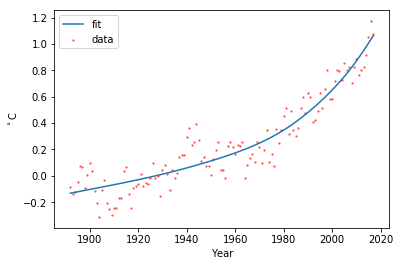

0.8499792441499435
48.79836621777213
1.5898993717263181


In [23]:
tstart = 1892
yrswarm = warm.iloc[:,0]
yrswarm = yrswarm.tolist()
yrswarm = list(map(int, yrswarm))

tempswarm = warm.iloc[:,1]
tempswarm = tempswarm.tolist()
tempswarm = list(map(float, tempswarm))

istart = yrswarm.index(tstart)
# print (yrswarm)
# print (istart)
yrswarmi = yrswarm[istart:]
tempswarmi = tempswarm[istart:]
fixtemps = fixwarm.iloc[:,1]
# print (yrswarmi)
# print(tempswarmi)

# taui = tau /. t -> yrswarm
# err1 = Drop[(tempswarm - taui), istart - 1]
# fixerr1 = (fixtemps - taui)
# var = err1.err1
# fixvar = fixerr1.fixerr1

def tau(t,coef2,fix3,fix5):
# def tau(t,coef2,fix3):
    y = tau1(coef2,fix3,t) + tau2(coef2,fix3,t) + tau3(coef2,fix3,t) + tau4(coef2,fix3,t) + tau5(coef2,fix3,t) - tau6(coef2,fix3,t) - tau7(coef2,fix3,fix5,t) - tau8(coef2,fix3,t) + tau9(coef2,fix3,t) + tau10(coef2,fix3,t)
    return y

param_bounds=([0,0,0],[2,2,5])
popt, pcov = curve_fit(tau, yrswarmi, tempswarmi, bounds=param_bounds)
print (popt)

coef2fit = popt[0]
fix3fit = popt[1]
fix5fit = popt[2]

taufit = tau(yrswarmi, *popt)
plt.plot(yrswarmi,taufit,label="fit")
plt.xlabel('Year') 
plt.ylabel('$^\circ$C')
plt.scatter(yrswarmi,tempswarmi,s=2,color = 'r', alpha = 0.5,label ='data',marker='o')
# warm.plot.scatter(x, y,color = 'r',label ='data',alpha = 0.5,marker='o')
# df3.plot.scatter(x="Year", y="LUC", color = 'r',label ='shield', s=2, alpha = 0.5)
plt.legend(loc='best')
plt.savefig('taufit.eps',dpi=1000)
plt.savefig('taufit.pdf',dpi=1000)
plt.show()

lambdafit = 1.0*(tup0/ ctry2)/coef2fit
print(lambdafit)

c30fit = 30.667*fix3fit
print(c30fit)
print (fix5fit)


Extrapolate temperature

Net total radiative forcings

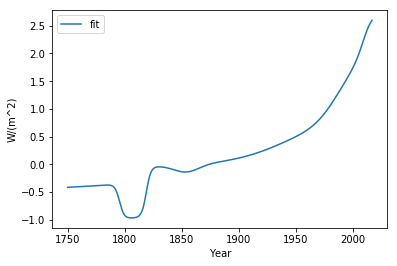

In [24]:
def fnet(t,fix5):
    y = f1(t) + f2(t) + f3(t) + f4(t) + f5(t) - f6(t) - f7(t,fix5) - f8(t) + f9(t) + f10(t)
    return y

def flongearly(t):
    y = f1(t) + f2(t) + f3(t) + f4(t) + f5(t)
    return y

def fshortearly(t,fix5):
    y = -f6(t) - f7(t,fix5) - f8(t) + f9(t) + f10(t)
    return y

def fnetearly(t,fix5): 
    y = flongearly(t) + fshortearly(t,fix5)
    return y

def fnetfit(t): 
    y = flongearly(t) + fshortearly(t,fix5fit)
    return y

yrs = list(range(t0,int(tmax)+1))
yrs = [int(i) for i in yrs]
plt.plot(yrs,fnetfit(yrs),label='fit')
plt.xlabel('Year')
plt.ylabel('W/(m^2)')
plt.legend(loc='best')
plt.savefig('fnetfit.eps',dpi=1000)

0.24505977369565518
[-0.00067362 -0.00677667 -0.06796018 -0.15706362  0.15794956  0.56431431
  0.12630571  0.0157132   0.07044161  0.11669799  0.15868126  0.14189747
 -0.22032797 -0.31879206  0.04754722 -0.02703416  0.00412915 -0.33155031
 -0.11135387 -0.09976625  0.12365745 -0.07305546  0.03007494 -0.0227981
 -0.07285576  0.01472506  0.13129471 -0.31616892 -0.03511881  0.06678899
 -0.08591923  0.06518963  0.01064857  0.13822481  0.2107559  -0.0980857
  0.09689377  0.04096011 -0.00133993 -0.11778328 -0.18839633 -0.07787157
 -0.06821566  0.04120793 -0.04346283  0.05390058  0.04774509 -0.04626249
 -0.17492953  0.03312476  0.11373508  0.05286486  0.07169661  0.25110281
  0.05048757  0.06169018  0.02689753  0.20462382  0.0551074  -0.00504435
 -0.17125263  0.02376176  0.01607887 -0.08317482  0.05973178  0.02287068
  0.1136145  -0.05884076  0.07944895 -0.07175852 -0.17841283  0.24544004
 -0.08287828 -0.04372843  0.00119536 -0.05927831  0.04121977  0.09742148
 -0.03376799 -0.09734918 -0.15191

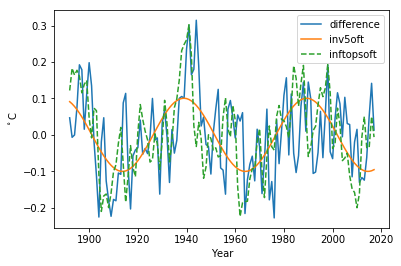

In [25]:
tempsuse = tempswarm[istart:]
yrsuse = yrswarm[istart:]
# print (tempsuse)

tempsearly = tempswarm[0:istart]
yrsearly = yrswarm[0:istart]
# taufitearly = 
# Table[taufit3 /. t -> yrsearly[[i]], {i, Length[yrsearly]}];
# print (tempsearly)
taufitearly = tau(yrsearly,*popt)
tempoffearly = np.mean(tempsearly - taufitearly)
print (tempoffearly)

taufiti = tau(yrsuse,*popt)
difi = tempsuse - taufiti
# print (difi)
nd = len(yrsuse)
dct = dct(difi, norm = 'ortho')
print (dct)
# print (nd)
rtops = np.sign(abs(dct) - 0.22)

itemindex = np.where(rtops==1)
# print (rtops)
print (itemindex)

# invn = (1/sqrt(nd))*dct[1]

def inv5oft(t):
    r = itemindex[0][0]
    s = t + tstart
#     y = (1/sqrt(nd))*2*dct[r]*np.cos(np.pi/(nd)*(r - 1)*(s - 1/2))
    y = (1/sqrt(nd))*2*dct[r]*np.cos(np.pi/(nd)*r*(s - 1/2))
    return y

inv5oft = np.vectorize(inv5oft)
print (dct[5])
print (dct[itemindex[0][0]])
print (dct[itemindex[0][1]])
print (itemindex[0][1])

def invn(t,r):
    s = t + tstart
#     y = (1/sqrt(nd))*2*dct[r]*np.cos(np.pi/(nd)*(r - 1)*(s - 1/2))
    y = (1/sqrt(nd))*2*dct[r]*np.cos(np.pi/(nd)*r*(s - 1/2))
    return y

invn = np.vectorize(invn)

def inftopsoft(t):
#     y = invn(t,itemindex[0][0]+1)+invn(t,itemindex[0][1]+1)+invn(t,itemindex[0][2]+1)+invn(t,itemindex[0][3]+1)+invn(t,itemindex[0][4]+1)+invn(t,itemindex[0][5]+1)+invn(t,itemindex[0][6]+1)
    y = invn(t,itemindex[0][0])+invn(t,itemindex[0][1])+invn(t,itemindex[0][2])+invn(t,itemindex[0][3])+invn(t,itemindex[0][4])+invn(t,itemindex[0][5])+invn(t,itemindex[0][6])
    return y
# print (itemindex[0][1]+1)

plt.plot(yrsuse,difi, label='difference')
tplot = list(range(tstart, int(tmax)+1))
tplot = [int(i) for i in tplot]
plt.plot(tplot,inv5oft(tplot), label='inv5oft')
plt.plot(tplot,inftopsoft(tplot), label='inftopsoft',ls='--')
plt.legend(loc='best')
plt.xlabel('Year')
plt.ylabel('$^\circ$C')
plt.savefig('wu.eps',dpi=1000)
plt.show()

# ys = NDSolve[{y'[x] == y[x] Cos[x + y[x]], y[0] == 1}, y, {x, 0, 30}];

Fitting parameters C8 in extrapolation formula

In [26]:
ci = [0, 0 ,0, 1/gtonnecperppm, 0.5964, 0.5, 1350, 0.48, 0.40, 0.12, 3]
temp1 = 1
ca0 = 0.277853*ci[3]
print(ca0)
# ntry = 5
ntry = 6
# tryc8 = list(range(3721,3729,1))
# tryc8 = np.linspace(0.3721,0.3725,ntry)
tryc8 = np.linspace(0.3721,0.3726,ntry)
# tryc8 = [x /10000 for x in tryc8]
print (tryc8)
tryc9 = [1-x for x in tryc8]
# tryc9 = np.linspace(0.6279, 0.6275,5)
print (tryc9)
print (b1[3])

0.13044741784037558
[0.3721 0.3722 0.3723 0.3724 0.3725 0.3726]
[0.6279, 0.6278, 0.6277, 0.6275999999999999, 0.6275, 0.6274]
0.242542


In [27]:
def e11(t):
    y = b1[nm[0][0]-1]/(1 + exp(-(t - b2[nm[0][0]-1])/b3[nm[0][0]-1])) # annual emissions in Gtonne
    return y
print (e11(2011))

def gauss(t):
    y = b1[3] *np.exp(-0.5*((t-b2[3])/b3[3])**2)+ b1[4] *np.exp(-0.5*((t-b2[4])/b3[4])**2)+b1[5] *np.exp(-0.5*((t-b2[5])/b3[5])**2)+b1[6] *np.exp(-0.5*((t-b2[6])/b3[6])**2)
    return y

def flanduse(t):
    y = (b1[1]*exp((b2[1] - t)/b3[1]))/(b3[1]* (1 + exp((b2[1] - t)/b3[1]))**2)*b4[30]
    return y
# flanduse = np.vectorize(flanduse)

def e12(t):
    y = gauss(t) + flanduse(t)
    return y

# def e12(t):
#     y = 0.9655314973357574*exp(-0.0021585431378431277*(-1993.145114919485 + t)**2) + 0.7708724759669667*exp(-0.005996880782684809*(-1959.7283238701712+ t)**2) + 0.1999126265952924*exp(-0.016151643692490603*(-1932.7919330662555+ t)**2)+ 0.24286572421929586*exp(-0.0012950176466834183*(-1910.9407486714506+t)**2)+(2.597907733104079*exp(0.006142015686708064*(2003.38-t)))/(1 + exp(0.006142015686708064*(2003.38- t)))**2
#     return y

def e1(t):
    y = e11(t) + e12(t)
    return y

print (e12(2011))
print (flanduse(2011))
print (e1(2220))
print (b1[1])
print (b2[1])
print (b3[1])
print (b4[30])

9.097972310817717
1.1335933392914792
0.6487837762404931
18.666657752873768
3.4656599999999997
2003.34
162.813
121.984149588149


[[0.59182689]
 [0.59196926]
 [0.59211213]
 [0.59225552]
 [0.59239942]
 [0.59254385]
 [0.59268881]
 [0.59283429]
 [0.5929803 ]
 [0.59312683]
 [0.5932739 ]
 [0.59342151]
 [0.59356966]
 [0.59371834]
 [0.59386756]
 [0.59401732]
 [0.59416763]
 [0.59431848]
 [0.59446989]
 [0.59462185]
 [0.59477436]
 [0.59492744]
 [0.59508108]
 [0.59523528]
 [0.59539004]
 [0.59554538]
 [0.59570129]
 [0.59585777]
 [0.59601482]
 [0.59617246]
 [0.59633068]
 [0.59648949]
 [0.5966489 ]
 [0.59680889]
 [0.59696948]
 [0.59713067]
 [0.59729247]
 [0.59745487]
 [0.59761789]
 [0.59778152]
 [0.59794577]
 [0.59811065]
 [0.59827616]
 [0.5984423 ]
 [0.59860908]
 [0.5987765 ]
 [0.59894456]
 [0.59911328]
 [0.59928266]
 [0.5994527 ]
 [0.59962341]
 [0.59979479]
 [0.59996685]
 [0.6001396 ]
 [0.60031304]
 [0.60048719]
 [0.60066203]
 [0.6008376 ]
 [0.60101388]
 [0.60119088]
 [0.60136862]
 [0.60154711]
 [0.60172635]
 [0.60190635]
 [0.60208711]
 [0.60226866]
 [0.60245098]
 [0.6026341 ]
 [0.60281803]
 [0.60300278]
 [0.60318836]
 [0.60

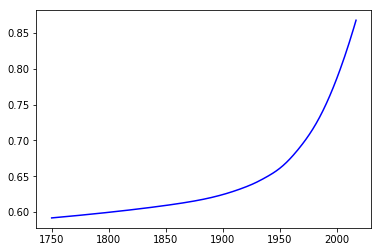

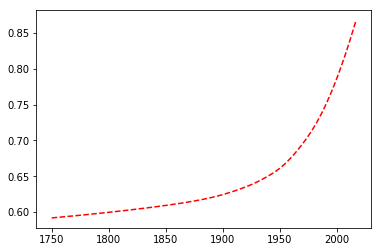

In [28]:
# function that returns dca/dt
def extrapolate(ca,t,c8):
    c9 = 1-c8
    dcadt = (c8 + c9*(ca - ci[4])/(ca + ci[5]*ci[4]))*e1(t)/1000-(ca - ci[4])/ci[6]
    return dcadt

# initial condition
ca0 = ci[4]*0.277853/0.280

# time points
t = np.linspace(t0, tmax, num=268)
# print (t)

# solve ODEs
c8 = tryc8[0]
y1 = odeint(extrapolate,ca0,t,args=(c8,))
# print (y1[0])
# print (y1[1])
print (y1)

c8 = tryc8[1]
y2 = odeint(extrapolate,ca0,t,args=(c8,))

c8 = tryc8[2]
y3 = odeint(extrapolate,ca0,t,args=(c8,))

c8 = tryc8[3]
y4 = odeint(extrapolate,ca0,t,args=(c8,))

c8 = tryc8[4]
y5 = odeint(extrapolate,ca0,t,args=(c8,))

c8 = tryc8[5]
y6 = odeint(extrapolate,ca0,t,args=(c8,))

# c8 = tryc8[6]
# y7 = odeint(extrapolate,ca0,t,args=(c8,))

# c8 = tryc8[7]
# y8 = odeint(extrapolate,ca0,t,args=(c8,))

#plot results
plt.figure()
plt.plot(t,y1,'b-')
plt.figure()
plt.plot(t,y5,'r--')
# plt.plot(t,y2,'r--')

268
[161.26824863449644, 161.19595483485617, 161.16932107527478, 161.18812263449425, 161.25239069813364]
[2.27542175e-02 4.08690273e+00 1.61169127e+02]


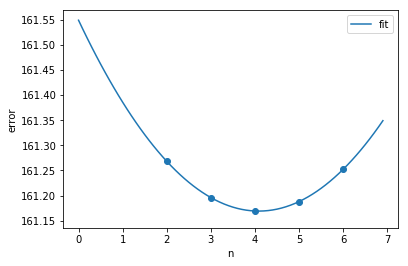

0.37240869027305484


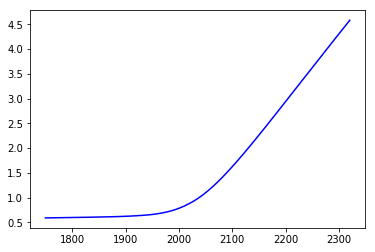

In [29]:
pairsco2 = df4[t0-1:-1]['ppb']
pairsco2 = pairsco2.tolist()
pairsco2 = [float(i) for i in pairsco2]
print (len(pairsco2))

difco21 = []
for i in range(0,len(pairsco2)):
    x = pairsco2[i]-1000*ci[3]*y1[i]
    difco21.append(float(x))
# print (difco21)
errn1 =  np.dot(difco21[200:],difco21[200:])
# print (errn1)
difco22 = []
for i in range(0,len(pairsco2)):
    x = pairsco2[i]-1000*ci[3]*y2[i]
    difco22.append(float(x))
# print (difco22)
errn2 = np.dot(difco22[200:],difco22[200:])
# print (errn2) 

difco23 = []
for i in range(0,len(pairsco2)):
    x = pairsco2[i]-1000*ci[3]*y3[i]
    difco23.append(float(x))
# print (difco23)
errn3 = np.dot(difco23[200:],difco23[200:])
# print (errn3)

difco24 = []
for i in range(0,len(pairsco2)):
    x = pairsco2[i]-1000*ci[3]*y4[i]
    difco24.append(float(x))
# print (difco23)
errn4 = np.dot(difco24[200:],difco24[200:])
# print (errn4)

difco25 = []
for i in range(0,len(pairsco2)):
    x = pairsco2[i]-1000*ci[3]*y5[i]
    difco25.append(float(x))
# print (difco23)
errn5 = np.dot(difco25[200:],difco25[200:])
# print (errn5)

difco26 = []
for i in range(0,len(pairsco2)):
    x = pairsco2[i]-1000*ci[3]*y6[i]
    difco26.append(float(x))
# print (difco23)
errn6 = np.dot(difco26[200:],difco26[200:])
# print (errn6)

# difco27 = []
# for i in range(0,len(pairsco2)):
#     x = pairsco2[i]-1000*ci[3]*y7[i]
#     difco27.append(float(x))
# # print (difco23)
# errn7 = np.dot(difco27[200:],difco27[200:])
# # print (errn7)

# difco28 = []
# for i in range(0,len(pairsco2)):
#     x = pairsco2[i]-1000*ci[3]*y8[i]
#     difco28.append(float(x))
# # print (difco23)
# errn8 = np.dot(difco28[200:],difco28[200:])
# # print (errn8)

# nfitlist = list(range(0,8))
nfitlist = list(range(2,7))

# errn = [errn1,errn2,errn3,errn4,errn5,errn6,errn7,errn8]
errn = [errn2,errn3,errn4,errn5,errn6]
# errn = [160.927, 160.865, 160.848, 160.878, 160.952]
print (errn)
plt.scatter(nfitlist,errn)

# fullfit = interp1d(nfitlist, errn,kind= 'cubic')
# fullfit = CubicSpline(nfitlist, errn)

def quadratic(n,a1,a2,a3):
    y = a1*(n-a2)**2+a3
    return y
param_bounds=([-100,0,-150],[100,5,200])
popt1, pcov1 = curve_fit(quadratic, nfitlist , errn, bounds=param_bounds)
print (popt1)

# tck = interpolate.splrep(nfitlist, errn)
xnew = np.arange(0, 7, 0.1)
# ynew = interpolate.splev(xnew, tck, der=0)
ynew = quadratic(xnew, *popt1)
plt.plot(xnew,ynew, label ='fit')
plt.xlabel('n')
plt.ylabel('error')
plt.legend(loc='best')
plt.show()
# plt.plot(nfitlist,fullfit(nfitlist))

# res_1 = least_squares(fullfit,2) #Solve a nonlinear least-squares problem with bounds on the variables.
# # res_1 = least_squares(ynew,3) #Solve a nonlinear least-squares problem with bounds on the variables.
# print (res_1.x)

# # # res = minimize_scalar(fullfit, bounds=(2, 6), method='bounded')
# # # print (res.x)

# c8fit = 0.372 + 0.0001*res_1.x
c8fit = 0.372 + 0.0001*popt1[1]
# c8fit = 0.372286
# c8fit = 0.372 + 0.0001*res.x
print (c8fit)

c9fit = 1-c8fit
tend = 2220
co20pp1000v = 0.277853

def extrapolate1(ca,t):
    c9fit = 1-c8fit
    dcadt = (c8fit + c9fit*(ca - ci[4])/(ca + ci[5]*ci[4]))*e1(t)/1000-(ca - ci[4])/ci[6]
    return dcadt

# initial condition
ca0 = ci[4]*co20pp1000v/0.280

t2 = 2020
# time points
# t = np.linspace(t0, tend, num=471)
t = np.linspace(t0, tend+100, num=571)
# print (t0)

# solve ODEs
y9 = odeint(extrapolate1,ca0,t)
# intersection = [float(y) for x in y9 for y in x] # convert the nested list in python
# print (y9)
#plot results
plt.figure()
plt.plot(t,y9,'b-')

[0.88458904]
[1.62659304]
[[ 277.853     ]
 [ 277.91989613]
 [ 277.98702533]
 [ 278.05439857]
 [ 278.12201584]
 [ 278.18987811]
 [ 278.25798778]
 [ 278.32634499]
 [ 278.39494973]
 [ 278.46379943]
 [ 278.53290733]
 [ 278.6022646 ]
 [ 278.6718722 ]
 [ 278.74173184]
 [ 278.81184528]
 [ 278.88221378]
 [ 278.95283858]
 [ 279.02372096]
 [ 279.09486216]
 [ 279.16626345]
 [ 279.23792608]
 [ 279.30985128]
 [ 279.38204017]
 [ 279.45449397]
 [ 279.5272139 ]
 [ 279.60020119]
 [ 279.67345705]
 [ 279.74698272]
 [ 279.82077941]
 [ 279.89484844]
 [ 279.96919194]
 [ 280.04381161]
 [ 280.11870894]
 [ 280.19388541]
 [ 280.26934252]
 [ 280.34508176]
 [ 280.4211046 ]
 [ 280.49741255]
 [ 280.574008  ]
 [ 280.65089347]
 [ 280.72807082]
 [ 280.80554191]
 [ 280.8833086 ]
 [ 280.96137274]
 [ 281.03973621]
 [ 281.11840086]
 [ 281.19736903]
 [ 281.27664419]
 [ 281.35622881]
 [ 281.43612528]
 [ 281.51633599]
 [ 281.59686334]
 [ 281.67770971]
 [ 281.75887837]
 [ 281.84037314]
 [ 281.92219696]
 [ 282.00435275]
 [ 28

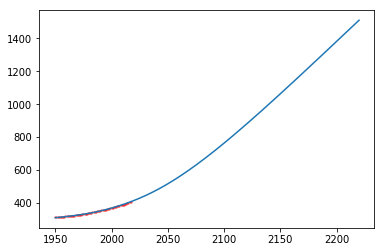

In [30]:
cafitatt2 = y9[270] # cafit function fitted value at year 2020
cafitatt3 = y9[350] # fitted value at year 2100
t1 = 1950
print (cafitatt2)
print (cafitatt3)
# co2fit = 1000*y9*ci[3] # from year t0 to tend that is 1750 to 2220
co2fit = 1000*y9*ci[3] # from year t0 to tend that is 1750 to 2320
print (co2fit)
# co2fituse = co2fit[200:] # from year t1 to tend that is 1950 to 2220
co2fituse = co2fit[200:-100] # from year t1 to tend that is 1950 to 2220
print (co2fituse)
print (len(co2fituse))

# print (len(co2fit))
pairsco2late = pairsco2[200:]
# print (pairsco2)
# print (pairsco2late)
t = np.linspace(t1, tend, num=271)
plt.plot(t,co2fituse)
t4 = np.linspace(t1, 2017, num=68)
plt.scatter(t4,pairsco2late,s=2,color = 'r', alpha = 0.5,label ='data',marker='o')

271
[[0.58831618]
 [0.59863447]
 [0.60932924]
 [0.62040548]
 [0.63186376]
 [0.64369996]
 [0.65590591]
 [0.66846927]
 [0.68137476]
 [0.6946044 ]
 [0.70813894]
 [0.72195863]
 [0.73604439]
 [0.75037884]
 [0.76494726]
 [0.77973851]
 [0.79474548]
 [0.80996569]
 [0.8254013 ]
 [0.84105913]
 [0.85695018]
 [0.87308923]
 [0.88949426]
 [0.90618561]
 [0.92318526]
 [0.94051599]
 [0.9582006 ]
 [0.97626129]
 [0.99471892]
 [1.01359265]
 [1.03289941]
 [1.05265381]
 [1.07286775]
 [1.09355056]
 [1.11470883]
 [1.13634665]
 [1.15846564]
 [1.18106511]
 [1.20414227]
 [1.22769259]
 [1.25170973]
 [1.27618621]
 [1.30111335]
 [1.3264815 ]
 [1.35228049]
 [1.37849957]
 [1.40512791]
 [1.43215464]
 [1.45956898]
 [1.4873606 ]
 [1.51551958]
 [1.54403658]
 [1.57290303]
 [1.60211138]
 [1.63165473]
 [1.66152696]
 [1.69172298]
 [1.72223866]
 [1.75307067]
 [1.7842165 ]
 [1.81567438]
 [1.84744325]
 [1.8795226 ]
 [1.91191241]
 [1.94461302]
 [1.97762507]
 [2.0109493 ]
 [2.04458656]
 [2.07853763]
 [2.11280312]
 [2.14738342]
 [

Text(20.625,0.5,'W/m^2')

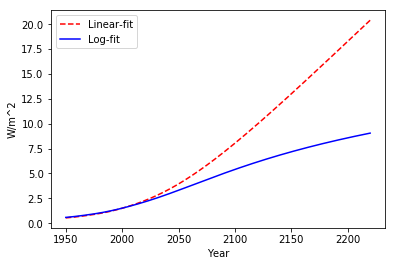

In [31]:
# tco2 = pairsco2[:,0]
tco2 = df4[t0-1:-1]['Julian']
# pairsco2 = pairsco2.tolist()
# pairsco2 = [float(i) for i in pairsco2]
# print (df4)
# tco2 = df4[t0-1:-1]['ppb']
gco2linear = b2[17]*(co2fit - 1000*co20pp1000v)
gco2ln = 5.35*log(co2fit/278)
# gco2linearuse = gco2linear[200:]
# gco2lnuse = gco2ln[200:]
gco2linearuse = gco2linear[200:-100]
gco2lnuse = gco2ln[200:-100]
print (len(gco2lnuse))
print (gco2lnuse)
plt.plot(t,gco2linearuse,'r--',label="Linear-fit")
plt.plot(t,gco2lnuse,'b-',label="Log-fit")
plt.legend(loc='best')
plt.savefig('carbon_extrapolate.eps',dpi=1000)
plt.xlabel('Year')
plt.ylabel('W/m^2')

321
271


Text(36.625,0.5,'$^\\circ$C')

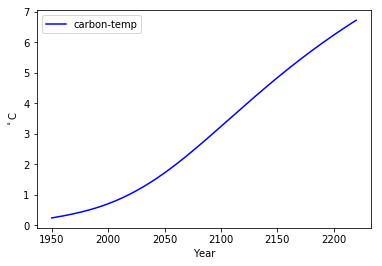

In [32]:
# initial condition
tauco20 = tau12(coef2fit,fix3fit,t1)
# print (tauco200)
# print (gco2ln[200])
# gco2lnuse = [float(x) for x in gco2lnuse] # convert the nested list in python
gco2lnuse1 = gco2ln[200:-50]
gco2lnuse1 = [float(x) for x in gco2lnuse1] # convert the nested list in python
print (len(gco2lnuse1))

# time points
tr = np.linspace(t1, tend+50, num=321)
# print (t)
g = interp1d(tr,gco2lnuse1,kind= 'cubic')
# plt.plot(t,g(t))

# print (len(g(t)))

# def csco2(tauco2,t,g):
#     dtauco2dt = (g(t) - tauco2/lambdafit)/(c30*fix3fit)
#     return dtauco2dt
def csco2(tauco2,t):
    dtauco2dt = (g(t) - tauco2/lambdafit)/(c30*fix3fit)
    return dtauco2dt
# time points
tff = np.linspace(t1, tend, num=271)
# solve ODEs
# g = tuple(gco2ln)
# for i in range(0,len(gco2lnuse)):
#     g = gco2lnuse[i]
y10 = odeint(csco2,tauco20,tff)
print(len(y10))
# for i in range(0,len(gco2ln)):
# g = gco2ln[0]
# y = odeint(csco2,tauco20,t,args=(g,))
# plot results
plt.figure()
plt.plot(tff,y10,'b-',label="carbon-temp")
plt.legend(loc='best')
plt.savefig('carbon_temp.eps',dpi=1000)
plt.xlabel('Year')
plt.ylabel('$^\circ$C')

Nitrous Oxide

In [33]:
n2o0 = 267.291
n2o1 = 280.219 # (* from heat18n2oforcing04mar.nb *)
def n2oemit(t):
    y = b1[10]/(1 + exp(-(t - b2[10])/b3[10]))
    return y
print (n2oemit(2011))

def sn2o(n2o,t):
    dn2odt = n2oemit(t)-(n2o - n2o0)/b4[10]
    return dn2odt

# initial condition
n2o00 = n2o1

# time points
t = np.linspace(t1, tend+100, num=571)

# solve ODEs
y11 = odeint(sn2o,n2o00,t)
# print (y11)

y11 = [float(x) for x in y11] # convert the nested list in python
n2ooft = interp1d(t,y11,kind= 'cubic')

1.3087155051635933


CH4

125.45649655835072


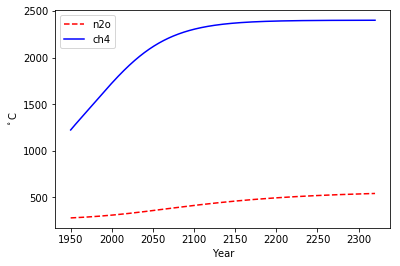

In [34]:
ch40 = 722.065
ch41 = 1224.4 # (* from heat18ch4forcing04mar.nb *)
def ch4emit(t):
    y = b1[8]/(1 + exp(-(t - b2[8])/b3[8]))
    return y
print (ch4emit(2011))

def sch4(ch4,t):
    dch4dt = ch4emit(t)-(ch4 - ch40)/b4[8]
    return dch4dt

# initial condition
ch400 = ch41

# time points
t = np.linspace(t1, tend+100, num=571)

# solve ODEs
y12 = odeint(sch4,ch400,t)
# print (y11)
#plot results
plt.plot(t,y11,'r--',label="n2o")
plt.plot(t,y12,'b-',label="ch4")
plt.legend(loc='best')
plt.xlabel('Year')
plt.ylabel('$^\circ$C') 
plt.savefig('tauboth.eps',dpi=1000)

y12 = [float(x) for x in y12] # convert the nested list in python
ch4oft = interp1d(t,y12,kind= 'cubic')

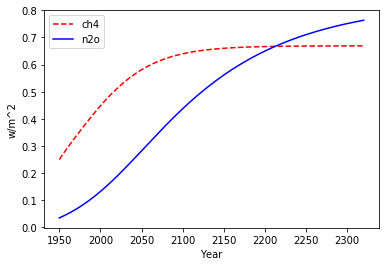

In [35]:
fmn0 = 0.47
fmn1 = 0.0000201
fmn2 = 5.31*10**-15
emn1 = 0.75
emn2 = 1.52
epsmn = 0.12
m0 = 722
n0 = 270

def fch4(t):
    y = fmn0*(1 + fmn1*(ch4oft(t)*n0)**emn1 + fmn2*m0*(m0*n0)**emn2)
    return y
def fn2o(t):
    y = fmn0*(1 + fmn1*(m0*n2ooft(t))**emn1 + fmn2*m0*(m0*n0)**emn2)
    return y
f00 = fmn0*(1 + fmn1*(m0*n0)**emn1 + fmn2*m0*(m0*n0)**emn2)

def forcech4(t): 
    y = beta*(sqrt(ch4oft(t)) - sqrt(m0)) - (fch4(t) - f00)
    return y

def forcen2o(t):
    y = epsmn*(sqrt(n2ooft(t))- sqrt(n0)) - (fn2o(t) - f00)
    return y
# print (forcech4(2011))
#plot results
plt.plot(t,forcech4(t),'r--',label="ch4")
plt.plot(t,forcen2o(t),'b-',label="n2o")
plt.legend(loc='best')
plt.xlabel('Year')
plt.ylabel('w/m^2') 
plt.savefig('forceboth.eps',dpi=1000)

In [36]:
def gch4n2o(t):
    y = forcech4(t) + forcen2o(t)
    return y

tauch4n21 = tau2(coef2fit,fix3fit,t1) + tau3(coef2fit,fix3fit,t1)
print (tauch4n21 )


def csch4n2o(tauch4n2o,t):
    dtauch4n2odt = (gch4n2o(t) - tauch4n2o/lambdafit)/(30.667*fix3fit)
    return dtauch4n2odt

# initial condition
tauch4n2o0 = tauch4n21

# time points
print (t1)
t = np.linspace(t1, tend+50, num=571)

# solve ODEs
y13 = odeint(csch4n2o,tauch4n2o0,t)
# print (tauboth)
#plot results
# print (tauboth[0])
y13 = [float(x) for x in y13] # convert the nested list in python
tauboth = interp1d(t,y13,kind= 'cubic')

0.1456155240324394
1950


271
271
0.24623616759509054
[1950. 1951. 1952. 1953. 1954. 1955. 1956. 1957. 1958. 1959. 1960. 1961.
 1962. 1963. 1964. 1965. 1966. 1967. 1968. 1969. 1970. 1971. 1972. 1973.
 1974. 1975. 1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984. 1985.
 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997.
 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009.
 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019. 2020. 2021.
 2022. 2023. 2024. 2025. 2026. 2027. 2028. 2029. 2030. 2031. 2032. 2033.
 2034. 2035. 2036. 2037. 2038. 2039. 2040. 2041. 2042. 2043. 2044. 2045.
 2046. 2047. 2048. 2049. 2050. 2051. 2052. 2053. 2054. 2055. 2056. 2057.
 2058. 2059. 2060. 2061. 2062. 2063. 2064. 2065. 2066. 2067. 2068. 2069.
 2070. 2071. 2072. 2073. 2074. 2075. 2076. 2077. 2078. 2079. 2080. 2081.
 2082. 2083. 2084. 2085. 2086. 2087. 2088. 2089. 2090. 2091. 2092. 2093.
 2094. 2095. 2096. 2097. 2098. 2099. 2100. 2101. 2102. 2103. 2104. 2105.
 2106. 2107. 2108. 2109

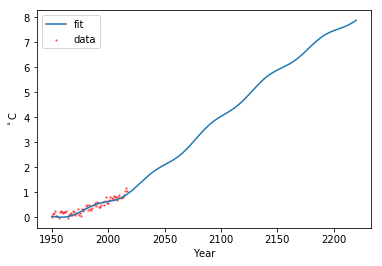

In [37]:
print (len(tff))
print (len(y10))
# print (t1)
y10 = np.asarray(y10).squeeze()
# tauboth = np.asarray(tauboth).squeeze()
tauco2ln = interp1d(tff,y10,kind= 'cubic')
print (tauco2ln(1950))

def tauother(t):
    y = tau4(popt[0],popt[1],t)+tau5(popt[0],popt[1],t)-tau6(popt[0],popt[1],t)-tau7(popt[0],popt[1],popt[2],t)-tau8(popt[0],popt[1],t)+tau9(popt[0],popt[1],t)+tau10(popt[0],popt[1],t)
    return y

def taunew(t):
    y = tauco2ln(t) + tauboth(t) + tauother(t) + inv5oft(t)
    return y
tfff = np.linspace(t1, tend, num=271)
print (tfff)
warmnew=warm.tail(-(t1-t0))
print (warmnew)
warmnew = warmnew.astype(float)
warmnew.plot.scatter(x="Julian", y="degreeC", color = 'r',label ='data', s=2, alpha = 0.5)
plt.plot(tfff,taunew(tfff),label="fit")
plt.legend(loc='best')
plt.xlabel('Year')
plt.ylabel('$^\circ$C') 
plt.savefig('fintemp.eps',dpi=1000)
plt.savefig('fintemp.pdf',dpi=1000)
print (taunew(1950))
print (t0)
print (inv5oft(1950))
print (tauother(1950))